In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from python_demo.models import mnist
from python_demo import LOT, FC, OT

##  Load Train and Test sample from MNIST

In [2]:
num_samples=1000  # number of train samples and test samples
torch.manual_seed(5)  # fix random seed

data_root = os.path.expanduser(os.path.join('/tmp/public_dataset/pytorch', 'mnist-data'))
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])  # Normalization

train_data = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=num_samples, shuffle=True)
X_train, y_train = next(iter(train_loader))

test_data = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=2*num_samples, shuffle=True)  # temporarily get more samples because of class removal
X_test, y_test = next(iter(test_loader))

##  Remove digits 0, 2 and 8 from test samples to create unbalanced setting

In [3]:
remove_classes = [0, 2, 8]
mask = torch.ones_like(y_test, dtype=torch.bool)
for idx in remove_classes:
    mask = torch.logical_and(mask, y_test != idx)

X_test = X_test[mask][:num_samples]
y_test = y_test[mask][:num_samples]

print(y_test.unique())

tensor([1, 3, 4, 5, 6, 7, 9])


##  Load model trained on training samples

In [4]:
m = mnist(pretrained=True).eval()

def compute_accuracy(net, X, y):
    pred_logits = net(X)
    _, pred_y = torch.max(pred_logits, 1)
    acc = (pred_y == y).sum().item() / y.size(0)
    return acc

print('Training accuracy:', compute_accuracy(m, X_train, y_train))
print('Testing accuracy:', compute_accuracy(m, X_test, y_test))

Training accuracy: 0.999
Testing accuracy: 0.982


##  Perturbation: apply dropout (or random masking) to test samples

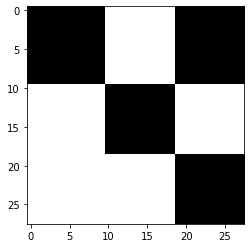

In [5]:
##  Create dropout mask
mask = np.ones_like(X_test[0])
mask[0, :10, :10] = 0; mask[0, :10, -9:] = 0; mask[0, -9:, -9:] = 0; mask[0, 10:-9, 10:-9] = 0

plt.imshow(mask[0],  cmap='gray')
plt.show()

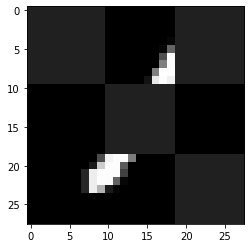

In [6]:
##  Apply dropout mask to test images
X_test_aug = torch.Tensor(X_test * mask)
plt.imshow(X_test_aug[1].squeeze(),  cmap='gray')
plt.show()

In [7]:
## Evaluate accuracy
print('Accuracy of augmented test data:', compute_accuracy(m, X_test_aug, y_test))

Accuracy of augmented test data: 0.693


##  Get model's logits output for each set
MLP --> logits (10d)

In [8]:
features_train = m(X_train).detach().numpy()
features_test = m(X_test).detach().numpy()
features_test_aug = m(X_test_aug).detach().numpy()

## Applying LOT
- Source = features_test_aug
- Target = features_train

In [66]:
%%time
n_source_anchors = 7
n_target_anchors = 10
eps = 50

lot = LOT(n_source_anchors= n_source_anchors, n_target_anchors= n_target_anchors, epsilon=eps, epsilon_z=eps)
lot.fit(features_test_aug, features_train)

CPU times: user 7.01 s, sys: 1.33 s, total: 8.35 s
Wall time: 1.32 s


In [67]:
%%time
# estimate transport plan
transported_features_lot = lot.transport(features_test_aug, features_train)

CPU times: user 6.73 ms, sys: 4.58 ms, total: 11.3 ms
Wall time: 1.82 ms


In [68]:
%%time
# more robust estimation of transport plan
transported_features_robust_lot = lot.robust_transport(features_test_aug, features_train)

CPU times: user 10.9 ms, sys: 12.4 ms, total: 23.3 ms
Wall time: 4.31 ms


In [69]:
def compute_accuracy_from_logits(logits, labels):
    _, pred_y = torch.max(torch.tensor(logits), 1)
    return (pred_y == labels).sum().item() / labels.size(0)

aLOT = compute_accuracy_from_logits(transported_features_lot, y_test)
eLOT = np.linalg.norm(transported_features_lot - features_test)
print('Accuracy after LOT:', aLOT)
print('L2 error of LOT:', eLOT)

aLOTr = compute_accuracy_from_logits(transported_features_robust_lot, y_test)
eLOTr = np.linalg.norm(transported_features_robust_lot - features_test)
print('Accuracy after LOT (robust):', aLOTr)
print('L2 error of LOT (robust):', eLOTr)

Accuracy after LOT: 0.71
Accuracy after LOT (robust): 0.741
L2 error of LOT: 417.4369120075038
L2 error of LOT (robust): 396.541179209524


## Applying FC


In [70]:
%%time

n_anchors = 10
fc = FC(n_anchors= n_anchors, epsilon=eps)
fc.fit(features_test_aug, features_train)

CPU times: user 6.3 s, sys: 1.47 s, total: 7.77 s
Wall time: 1.18 s


In [71]:
%%time
# estimate transport plan
transported_features_fc = fc.transport(features_test_aug, features_train)

CPU times: user 9.09 ms, sys: 7.49 ms, total: 16.6 ms
Wall time: 3.02 ms


In [72]:
aFC = compute_accuracy_from_logits(transported_features_fc, y_test)
print('Accuracy after FC :', aFC)

eFC = (np.linalg.norm(transported_features_fc - features_test))
print('L2 error of FC:', eFC)

Accuracy after FC : 0.7
L2 error of FC: 437.23615356577955


## Applying OT

In [73]:
%%time
ot = OT()
ot.fit(features_test_aug, features_train)

CPU times: user 468 ms, sys: 24 ms, total: 492 ms
Wall time: 494 ms


In [74]:
%%time
# estimate transport plan
transported_features_ot = ot.transport(features_test_aug, features_train)

CPU times: user 10.4 ms, sys: 6.63 ms, total: 17 ms
Wall time: 3.01 ms


In [75]:
aOT = compute_accuracy_from_logits(transported_features_ot, y_test)
print('Accuracy after OT :', aOT)

eOT = (np.linalg.norm(transported_features_ot - features_test))
print('L2 error of OT:', eOT)

Accuracy after OT : 0.613
L2 error of OT: 542.2029884453121


## Summary

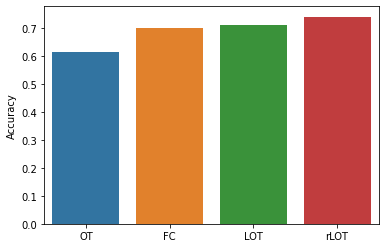

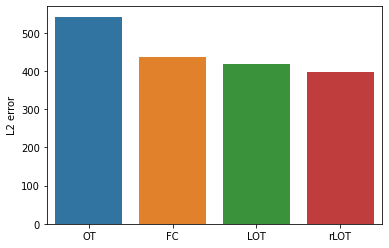

In [92]:
methods = ['OT','FC','LOT','rLOT']
accuracies = [aOT, aFC, aLOT, aLOTr]
sns.barplot(x=methods, y=accuracies)
plt.ylabel('Accuracy')
plt.show()

error = [eOT, eFC, eLOT, eLOTr]
sns.barplot(x=methods, y=error)
plt.ylabel('L2 error')
plt.show()

## Visualization

In [93]:
# Dimensionality reduction
# We fit an isomap to the target (train samples) and use it to project all sets in a common 2-d space

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_neighbors=50)
isomap.fit(features_train)

Isomap(n_neighbors=50)

In [1]:
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['tab:gray', 'tab:blue', 'tab:purple', 'tab:orange', 'tab:green', 'tab:red', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan'])
c_test = cmap(y_test)
c_train = cmap(y_train)

plt.figure(figsize = (20,10))
# todo train has different color map
plt.subplot(2,3,1); plt.scatter(*isomap.transform(transported_features_fc).T, c=c_test); plt.title('factored coupling')
plt.subplot(2,3,2); plt.scatter(*isomap.transform(transported_features_ot).T, c=c_test); plt.title('OT')
plt.subplot(2,3,3); plt.scatter(*isomap.transform(transported_features_robust_lot).T, c=c_test); plt.title('LOT')
plt.subplot(2,3,4); plt.scatter(*isomap.transform(features_test).T, c=c_test); plt.title('test ground truth')
plt.subplot(2,3,5); plt.scatter(*isomap.transform(features_train).T, c=c_train); plt.title('train set')
plt.subplot(2,3,6); plt.scatter(*isomap.transform(features_test_aug).T, c=c_test); plt.title('dropped out test set')
plt.show()

NameError: name 'y_test' is not defined